# Project summary

To be filled out later

# Data import and cleaning

## Importing libraries and seperating DataFrames

We begin be importing the libraries.

In [7]:
#Importing external libraries
import math
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
import xgboost as xgb

#Importing classes and functions from external files:
from model_classes import ModelSwitcher, DataPreprocessor
from cleaning_functions import *
from feature_engineering import *
from visualization_functions import *

#Configuring options
%matplotlib inline
pd.set_option('display.max_columns', 50)

In [2]:
df_outcomes = pd.read_csv("DATASETS/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv")
test_set = pd.read_csv("DATASETS/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv")
df = pd.read_csv("DATASETS/4910797b-ee55-40a7-8668-10efd5c1b960.csv")
target_col = "status_group"

Merging the test set with the set for evaluation before data cleaning optimizes the process by having the full scope of the values from the start.

In [3]:
df_c = pd.concat([df,test_set], axis=0).copy()

Created a seperate dataframe for EDA which combines the training set and their respective values.

In [4]:
df_j = pd.merge(df, df_outcomes, how="left", on="id")

In [5]:
def main_data_cleaning(df):
    df = df.drop(columns=["recorded_by"])
    df = simp_datetime_map(df, "date_recorded")
    return df

## Dealing with missing data

I stored parameters for the imputer functions to process all all of the missing data within OrderedDicts which will be fitted/transformed in bulk through the use of loops. The functtions also create a dummy variable for each indicating that the data was from a missing source within this process to preserve as much information as possible.

The rationale for including some of the entries in the dictionary are explained in the further sections.

In [6]:
impute_dict = OrderedDict([("construction_year",[0, "median", None]),
                          ("population",[0, "median", None]),
                           ("amount_tsh",[0, "constant", .01]),
                            ("subvillage",[np.nan, "constant", "Unknown"]),
                            ("public_meeting",[np.nan, "most_frequent", None]),
                           ("scheme_name",[np.nan, "constant", "Unknown"]),
                           ("permit",[np.nan, "most_frequent", None]),
                          ])

impute_cat_dict = {"funder":["0", "Unknown"],
                   "installer":["0", "Unknown"],
                   "scheme_management":["None", "Unknown"],
                  }

In [7]:
imputes = get_imputer_objs(df_j, impute_dict)

In [8]:
df_c = impute_vals(df_c, impute_dict, imputes)
df_j = impute_vals(df_j, impute_dict, imputes)

df_c=impute_mult_categorical(df_c, impute_cat_dict)
df_j=impute_mult_categorical(df_j, impute_cat_dict)

In [9]:
df_c = main_data_cleaning(df_c)
df_j = main_data_cleaning(df_j)

In [10]:
df_c.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'missing_construction_year', 'missing_population',
       'missing_public_meeting', 'missing_permit'],
      dtype='object')

In [13]:
# df_c.info()
full_value_counts(df_c, "latitude")


There are 71869 unique values with 0 nan values making up 0.0%
2269--2e-08
2--6.98012199
2--6.98077879
2--2.46713695
2--6.9644683
2--6.97393009
2--2.50162744
2--7.16249333
2--7.10374232
2--6.98945622
2--2.51995041
2--6.96355665
2--2.51661892
2--7.06053111
2--3.34243236
2--7.10013213
2--6.99261144
2--2.51532072
2--2.49080182
2--7.10591905
2--2.490689
2--7.09516233
2--6.98318263
2--6.99004232
2--2.52871573
2--6.95674564
2--6.95871592
2--7.10492257
2--6.98019707
2--7.17715478
2--9.2893492
2--7.17160463
2--6.95732845
2--7.17083546
2--6.98360619
2--6.98200774
2--7.10462503
2--6.97391498
2--6.99054864
2--7.17066586
2--6.99073094
2--6.97832237
2--7.0939143
2--6.96430094
2--6.99545576
2--6.98182996
2--6.98602609
2--6.96816345
2--6.979910899999999
2--6.978755499999999
2--6.95971938
2--6.9813255000000005
2--6.98300812
2--3.79757861
2--6.9802203999999985
2--6.98738163
2--2.4943533
2--6.97559391
2--6.98267879
2--7.05692253
2--2.48522658
2--2.51661939
2--7.07808103
2--7.06537264
2--6.9642576
2--6.9

1--9.21794044
1--10.20557747
1--3.80534461
1--5.22021295
1--9.39296196
1--10.59814469
1--10.87863575
1--8.13717158
1--3.3600925000000004
1--9.59165006
1--1.97639307
1--3.59017085
1--6.11662444
1--2.99022954
1--10.4299215
1--3.58712364
1--9.04182524
1--6.08071234
1--8.39195096
1--2.05659182
1--6.07246324
1--9.00538753
1--1.82704651
1--6.53583716
1--5.48176531
1--4.9275631
1--10.40109388
1--10.55219409
1--3.56721368
1--9.35813525
1--9.35840452
1--3.63073122
1--10.77450005
1--3.86025881
1--6.85064751
1--4.06897523
1--1.83412267
1--5.60221845
1--4.59648028
1--3.34318106
1--4.49156523
1--4.94356375
1--8.92424207
1--2.86663153
1--8.56484576
1--3.36367145
1--10.74474317
1--5.35080059
1--3.22957948
1--7.98802343
1--3.36979341
1--2.47182032
1--4.21727702
1--9.29921129
1--3.28438222
1--11.2208012
1--9.32512737
1--3.73625099
1--10.72902255
1--3.12451662
1--7.35466879
1--8.01381771
1--8.08985437
1--3.62430204
1--3.34281382
1--3.91691102
1--5.40038315
1--1.4405159
1--10.45936501
1--6.74464483
1--4.

1--3.4665361000000003
1--8.8700959
1--3.76461634
1--8.01846305
1--3.53675397
1--9.79634455
1--1.68065404
1--4.56207105
1--3.73986409
1--11.05307048
1--3.33574782
1--4.27929971
1--4.8260739
1--10.27372779
1--10.29826549
1--3.84218793
1--4.74275388
1--3.28468532
1--6.51054535
1--11.24619307
1--9.28567929
1--4.48305656
1--11.14036104
1--5.145552
1--5.6815313
1--3.24114014
1--6.27211545
1--10.86560823
1--4.80918279
1--9.75679719
1--4.6498003
1--3.53905912
1--8.85658275
1--1.6364898
1--4.65532148
1--3.24181939
1--7.0994868
1--9.46548497
1--10.59972249
1--4.480313
1--2.12743151
1--4.74646734
1--3.65560611
1--7.64448154
1--3.58836276
1--9.0479805
1--5.14130443
1--6.52156451
1--5.81119376
1--9.11660743
1--7.59061861
1--5.52881779
1--2.90025754
1--9.1177336
1--8.85484985
1--9.01509636
1--6.96685369
1--2.67963648
1--2.03451755
1--1.50566451
1--8.86007736
1--4.72714674
1--7.27565488
1--9.65682551
1--4.988929
1--7.55002607
1--3.25896034
1--9.19312451
1--3.32930755
1--10.6999143
1--5.02257899
1--8.

1--2.72675389
1--8.74511029
1--1.26802395
1--3.03756692
1--3.33990713
1--8.68899341
1--10.8113469
1--8.14181809
1--2.07162035
1--1.55907447
1--11.32243239
1--3.43879254
1--3.27306034
1--10.70187207
1--2.1490822
1--1.78644111
1--3.40669286
1--5.40828484
1--4.46089382
1--9.19406902
1--6.59189879
1--4.76986454
1--3.83205278
1--5.11575473
1--2.98252193
1--9.0797788
1--3.58152845
1--3.17029987
1--8.64379763
1--9.47697864
1--7.1780977
1--9.49953475
1--4.71155471
1--7.82572552
1--4.49368603
1--9.41632816
1--4.6478123
1--1.16228696
1--7.88369226
1--4.19338096
1--4.59370212
1--9.40619122
1--2.97046283
1--3.35601773
1--4.278109
1--3.52478741
1--10.91150172
1--8.50431088
1--6.91296091
1--4.21472883
1--1.63194994
1--3.59130344
1--11.13662166
1--6.51740019
1--4.81741505
1--4.865556099999999
1--8.77350039
1--6.97585053
1--3.86359789
1--3.23380781
1--6.04559852
1--3.52054253
1--7.97306486
1--8.62537947
1--6.33557245
1--3.29812145
1--5.61542321
1--3.00965923
1--6.13452082
1--4.22321932
1--4.63941377
1

1--5.33403549
1--6.78668505
1--3.71753771
1--3.75166852
1--1.19871142
1--8.99817382
1--8.70167525
1--2.50382785
1--3.74430797
1--1.74581674
1--10.66168464
1--3.25755535
1--7.47673909
1--8.89752035
1--6.78303139
1--1.59188849
1--4.93525086
1--10.88089637
1--6.65697199
1--10.26648339
1--8.52382514
1--9.32841692
1--3.84381623
1--7.88323857
1--5.06363729
1--3.32014109
1--5.13220944
1--4.16972528
1--5.87024621
1--3.35324555
1--3.26395442
1--10.43521548
1--10.33088374
1--10.79642253
1--1.65223242
1--10.86660812
1--3.34668731
1--1.55432526
1--5.03342774
1--7.19012071
1--4.5642623
1--3.45016619
1--6.72305607
1--7.73341264
1--3.32296755
1--5.62945232
1--6.11394944
1--9.08118607
1--8.51127212
1--4.40755173
1--3.24107096
1--3.14762633
1--3.73186727
1--10.38706667
1--10.29221103
1--10.96893662
1--4.20289312
1--3.27438211
1--4.39149489
1--3.28649037
1--4.782759099999999
1--8.38378327
1--5.69177506
1--4.72398826
1--3.12214007
1--1.99738762
1--4.41049324
1--6.73019325
1--8.66837791
1--1.16371243
1--8

1--1.14779377
1--7.345258900000001
1--10.66822784
1--1.69611591
1--10.02519442
1--2.93475882
1--6.82353339
1--8.15034329
1--6.76389413
1--3.30361983
1--4.85923042
1--5.62191383
1--9.34506908
1--4.31547568
1--8.84086531
1--3.5463395
1--3.29664103
1--8.80592003
1--10.14750269
1--4.81611235
1--9.49567154
1--6.01293371
1--1.55147568
1--10.40190485
1--4.26270409
1--6.90224954
1--3.36228004
1--4.38764287
1--10.30003507
1--4.44068724
1--2.06666064
1--2.62240663
1--3.49762214
1--3.4718039
1--5.02149501
1--10.86562076
1--3.17396247
1--3.57466131
1--6.77381547
1--3.34854687
1--5.61618879
1--9.84746213
1--2.70105967
1--4.30558466
1--4.51595034
1--3.22945722
1--9.33268276
1--1.48289452
1--3.29816814
1--7.28982862
1--4.66664122
1--6.84600824
1--9.12410861
1--4.49124279
1--5.01016018
1--8.4401519
1--3.57558703
1--4.60338832
1--9.22581024
1--2.99328854
1--5.39892668
1--3.66327511
1--3.31599868
1--5.49680764
1--5.76651142
1--3.30395104
1--3.2574688
1--3.35827906
1--4.4514775
1--6.77779865
1--7.1007232

1--3.36194631
1--4.27612849
1--7.90786137
1--4.1521081
1--4.5601011
1--1.12580195
1--4.65243373
1--1.28304137
1--5.88773375
1--3.26358388
1--10.88497239
1--3.99015658
1--1.77857498
1--6.64120537
1--10.03876225
1--6.29621671
1--7.17035714
1--3.45197718
1--10.97719279
1--7.22613031
1--9.60575378
1--9.1778218
1--8.53695049
1--5.78157866
1--1.747108
1--9.54472111
1--4.652450900000002
1--3.18409618
1--9.13324146
1--1.37627066
1--6.21286842
1--6.40278148
1--4.45828289
1--1.77497949
1--9.21065328
1--4.12114964
1--9.01531636
1--3.50838546
1--7.29372762
1--3.62909581
1--2.5349009
1--4.68607957
1--7.07501037
1--10.54044235
1--3.29079461
1--4.39622142
1--10.23447362
1--4.89846411
1--4.96097056
1--6.05270543
1--4.83649009
1--4.86083077
1--1.61459173
1--2.84887833
1--6.88680449
1--3.16088899
1--1.66907509
1--10.29770087
1--2.5772945
1--6.928430499999998
1--3.55886501
1--2.87343801
1--2.61890124
1--5.80056728
1--4.16565234
1--7.10957456
1--3.16489255
1--2.55336983
1--3.42994522
1--4.45689348
1--3.02

1--3.41489257
1--3.29747664
1--6.4668138
1--4.77414072
1--9.06923162
1--3.21673322
1--2.71311956
1--11.04541718
1--3.49847727
1--8.77868104
1--7.96410835
1--8.617844900000001
1--4.20083741
1--2.33824478
1--2.12571166
1--6.19223525
1--6.01491011
1--10.79935762
1--8.25920676
1--10.96571112
1--2.50925215
1--3.21049315
1--4.67443943
1--2.40705186
1--9.42627039
1--7.98797869
1--3.0789346
1--3.32985981
1--3.47430839
1--4.76202045
1--4.66084039
1--4.03405989
1--8.77132872
1--1.38578104
1--4.6820698
1--2.87641591
1--5.01412844
1--10.98532438
1--1.00058519
1--5.99569676
1--2.50225413
1--7.15048345
1--9.26974958
1--10.64750171
1--4.48744334
1--1.40047092
1--10.20135481
1--3.64601111
1--4.81796519
1--6.77940591
1--2.83688986
1--3.59727464
1--6.96039601
1--9.34637862
1--2.06418321
1--2.52392502
1--4.94955958
1--8.89057201
1--6.25308769
1--6.9174231
1--8.213032
1--9.23029781
1--1.53515737
1--10.11473051
1--9.7770212
1--6.99350277
1--1.24644694
1--4.2771942
1--9.54423007
1--6.48597766
1--6.29499897


1--9.28881073
1--9.05598847
1--6.48611425
1--8.21144184
1--10.86757986
1--3.62043913
1--6.31983789
1--4.69084344
1--7.43645829
1--4.14228556
1--8.73454982
1--3.29760999
1--4.12713325
1--4.96599462
1--9.03381466
1--2.93628442
1--4.58330072
1--11.20845618
1--5.40713167
1--11.12261819
1--5.09274087
1--4.93465907
1--7.40386107
1--7.68227544
1--3.51123715
1--10.30619034
1--5.47261693
1--9.6962565
1--9.14407432
1--7.87483593
1--8.54139182
1--6.81509556
1--8.78586542
1--3.19237616
1--2.91239912
1--1.44756447
1--4.58213705
1--7.77461052
1--3.70826364
1--3.40367702
1--4.46909114
1--4.6477294
1--8.91461398
1--9.00010771
1--1.35051797
1--4.80478242
1--4.7656959
1--3.38874279
1--10.79619297
1--7.00561337
1--3.59928252
1--9.20420598
1--3.66645328
1--9.78848225
1--3.34331266
1--10.62831471
1--11.16401287
1--8.07917896
1--10.81565894
1--3.48808794
1--9.1966273
1--10.53916339
1--11.200329
1--1.93828441
1--3.24126909
1--3.62244499
1--3.27336687
1--10.52441449
1--9.41269472
1--1.79858819
1--2.83652996
1

1--4.39533657
1--1.97539654
1--6.16688027
1--9.25050363
1--7.88458302
1--6.12366645
1--11.46053113
1--6.7628342
1--8.22694393
1--4.38978954
1--5.32212056
1--5.59796766
1--3.86319071
1--9.48473716
1--9.56157959
1--3.23948964
1--4.00087812
1--9.04133277
1--5.16592646
1--7.59904062
1--1.3963905
1--3.23354466
1--3.94064223
1--3.68626499
1--8.24927354
1--9.4332843
1--4.28102265
1--6.41082335
1--3.21907123
1--10.5453272
1--9.32576746
1--3.51394565
1--3.28439852
1--2.97641465
1--5.00470518
1--2.41383811
1--7.23960423
1--9.16606886
1--9.0196251
1--6.12482676
1--8.77321806
1--3.85741242
1--1.40558323
1--3.17697293
1--2.4625482999999995
1--9.3376303
1--2.5530318
1--4.06056976
1--1.83955426
1--8.928838699999998
1--4.24547886
1--4.6433846
1--4.16662662
1--8.65479697
1--2.60819102
1--4.90221141
1--9.05979195
1--1.7637693
1--7.36237327
1--8.98637288
1--8.60896763
1--9.3038411
1--10.75758548
1--3.38419823
1--4.93320563
1--3.29056752
1--3.66068516
1--3.10125365
1--2.46764408
1--7.88803042
1--1.5391801

1--2.51594712
1--2.46258835
1--6.87829912
1--6.0130367
1--4.90672946
1--10.33278285
1--7.1906212
1--6.86352262
1--8.74817714
1--3.87355206
1--10.27980898
1--3.6329154
1--9.77566731
1--6.54812088
1--10.26423429
1--1.73089976
1--4.97179672
1--1.50550628
1--7.31511328
1--5.42387123
1--6.75070709
1--7.37666685
1--9.05060187
1--10.86885138
1--9.62259041
1--7.56434964
1--2.56507993
1--8.78736302
1--6.3802677
1--11.1706075
1--6.34864274
1--3.24638805
1--9.76301681
1--2.49345547
1--10.40832085
1--1.26472927
1--5.11225408
1--4.40115282
1--10.19612385
1--8.22631515
1--6.06796835
1--4.76400705
1--5.51157293
1--5.8631871
1--4.57537406
1--9.96216226
1--6.9031152
1--3.81584414
1--3.19836028
1--2.04883778
1--3.86594662
1--4.20800294
1--4.47610308
1--6.36331303
1--10.88261521
1--3.78252288
1--3.58259249
1--2.00608767
1--4.24936845
1--9.16764609
1--4.84088109
1--6.99295128
1--8.70251674
1--7.67821728
1--4.19682658
1--3.45554288
1--10.03260671
1--1.61607992
1--1.25045332
1--4.24483031
1--4.3136283
1--7.

1--9.33473808
1--6.77989502
1--8.97179287
1--7.05706062
1--10.95932278
1--2.89109371
1--8.98903975
1--1.84481671
1--6.5647902999999985
1--9.56340763
1--10.22596195
1--9.1333113
1--2.5470462000000005
1--3.14695204
1--4.61554426
1--7.98682148
1--9.5053952
1--6.00869785
1--7.2443334
1--10.62961043
1--3.30344018
1--3.77377365
1--5.07893318
1--3.30355792
1--7.62488953
1--2.6159031
1--7.84915142
1--6.60746181
1--9.10311032
1--6.68001541
1--5.7841217
1--1.8898941
1--9.26164498
1--6.28249547
1--3.22117943
1--3.46178801
1--5.89134586
1--10.62482952
1--9.64011567
1--3.05165876
1--4.74721387
1--1.37970097
1--3.53000927
1--3.246389
1--3.50827843
1--3.58352399
1--3.13074815
1--8.58488888
1--3.38765995
1--3.76259244
1--4.53099715
1--8.52774277
1--4.38976585
1--8.04354822
1--6.97320593
1--2.00104864
1--3.07728558
1--2.08991419
1--2.53373963
1--5.42332551
1--8.88198153
1--7.59562483
1--10.33332581
1--3.75652019
1--9.23245087
1--1.43181392
1--4.92288182
1--6.49308674
1--3.17518268
1--7.38191068
1--2.06

1--3.04161801
1--7.97386876
1--6.82761372
1--5.8389894
1--4.18671094
1--4.80461982
1--10.68133544
1--2.54592077
1--9.04995286
1--5.75594214
1--8.84582271
1--4.27158606
1--3.3310238
1--3.56124218
1--4.28550469
1--3.84173725
1--8.08772959
1--4.8967952000000015
1--6.21821422
1--10.44423602
1--3.28470913
1--2.57639994
1--6.81420455
1--6.80779454
1--9.3643576
1--6.63332911
1--4.86727669
1--4.52166337
1--6.32430936
1--6.63502138
1--4.89580602
1--8.85159012
1--8.54480064
1--8.99137348
1--1.67972515
1--2.6531335
1--5.59899922
1--3.10774462
1--3.53219967
1--11.1606382
1--8.84303677
1--3.38106
1--3.64420177
1--3.32894774
1--3.40484838
1--4.67512268
1--4.40781127
1--9.27413327
1--6.10734302
1--2.99927213
1--7.238330499999999
1--9.1775723
1--4.48325389
1--10.11125803
1--3.13233048
1--7.42564669
1--10.88822583
1--4.20031995
1--9.37662288
1--5.15489918
1--10.90889841
1--11.30361856
1--3.11941345
1--11.16456557
1--2.80821179
1--10.55089458
1--5.10784297
1--4.33261259
1--1.20855239
1--4.69198422
1--4.

1--6.53861553
1--3.25625308
1--1.80181902
1--3.46012172
1--4.17576768
1--8.68364185
1--3.25820275
1--6.68643262
1--9.22668131
1--10.4888187
1--10.52452594
1--1.38298879
1--1.30370894
1--6.52715642
1--4.6521586
1--9.49641809
1--9.27215583
1--4.19656332
1--4.23070756
1--3.22572763
1--2.98057558
1--1.21251782
1--1.25380663
1--3.32507241
1--3.31608938
1--3.3031065
1--6.13546668
1--4.8571805
1--3.88061621
1--10.85007278
1--3.80980288
1--3.32741586
1--9.44605364
1--3.77730856
1--3.33755953
1--3.73827272
1--2.63913541
1--8.63559971
1--4.58382815
1--2.9198693
1--10.83127264
1--10.12118445
1--3.13538417
1--6.77933441
1--4.4295774
1--3.62129655
1--5.67632802
1--5.87623432
1--9.85877038
1--8.05876867
1--4.51237983
1--4.8476871
1--3.15845806
1--4.18068527
1--3.20759339
1--7.43900261
1--10.66210502
1--2.53171222
1--8.09209471
1--9.60709596
1--8.92582424
1--6.98686896
1--3.34770932
1--1.15458743
1--1.38907748
1--5.60001688
1--8.09810867
1--5.61856257
1--9.0798024
1--10.74478301
1--10.76032674
1--3.2

1--1.46821236
1--8.12715854
1--3.64461975
1--7.63557082
1--4.64201102
1--11.06619482
1--8.35298976
1--6.47132024
1--10.45521884
1--1.21378364
1--4.63705
1--2.73769303
1--6.79043185
1--9.08304933
1--11.42056165
1--1.59133016
1--9.35828541
1--1.56524393
1--10.58209144
1--8.7000246
1--6.25443591
1--3.24981319
1--4.58455611
1--8.28870356
1--8.65892463
1--8.12691688
1--9.97207624
1--3.95363719
1--4.66940854
1--4.24478448
1--9.49201243
1--3.24281455
1--3.33925521
1--6.61731042
1--8.13809229
1--10.67167121
1--9.42522353
1--7.9848482
1--5.17227682
1--8.96978104
1--2.57439932
1--10.49101086
1--5.60016753
1--6.37175887
1--3.78186381
1--4.5350605
1--7.23859102
1--3.01290742
1--6.74577126
1--11.04513765
1--9.28166252
1--10.54751327
1--7.67677413
1--10.71618294
1--3.33865809
1--3.11138978
1--4.23648582
1--3.34742132
1--1.47011524
1--3.28616638
1--3.00004964
1--8.89303333
1--5.79932239
1--1.27909609
1--7.43300294
1--1.57044813
1--2.88266379
1--2.46734089
1--5.92881534
1--8.1348791
1--3.1576212000000

1--7.97448837
1--7.20793451
1--3.49147365
1--10.03641169
1--4.11270072
1--8.11956301
1--9.4698033
1--8.44164595
1--5.30366478
1--3.15382218
1--4.21631225
1--6.85322823
1--3.45253836
1--3.60112663
1--6.44876312
1--8.87989153
1--8.23389501
1--10.58670021
1--4.88827862
1--3.73351894
1--5.61946449
1--5.44100922
1--10.60019912
1--10.7031507
1--4.21575508
1--5.7492172
1--8.85287276
1--3.53123976
1--2.71550239
1--6.80534835
1--4.7510195
1--1.89236667
1--6.22620731
1--3.43363525
1--6.89081513
1--8.97038617
1--6.90337376
1--2.15150244
1--3.80466763
1--5.39411307
1--5.12932031
1--6.14330374
1--7.95048578
1--2.56821835
1--8.96618739
1--3.37828355
1--10.019723
1--7.86305398
1--3.47809264
1--3.36782163
1--5.48751329
1--9.0145023
1--7.91014988
1--2.45091148
1--5.56053957
1--3.22558035
1--9.28104623
1--4.66218346
1--1.38946324
1--8.99705541
1--2.91220306
1--9.83156126
1--3.3337656000000004
1--10.23374913
1--8.11753386
1--8.71656903
1--9.9060747
1--4.70822714
1--6.4904237
1--9.78647086
1--9.59532927
1

1--4.75831506
1--1.37397572
1--6.96656294
1--3.51688804
1--10.82560602
1--6.32063448
1--4.99115568
1--7.83972684
1--8.13613979
1--10.98727483
1--6.97774009
1--4.75332103
1--8.3873517
1--9.15824088
1--6.7159692
1--4.77870484
1--3.85037678
1--6.78583594
1--4.00204808
1--3.24972631
1--2.69564854
1--10.09537366
1--9.89915992
1--1.43515282
1--4.37506615
1--3.35042967
1--4.50756724
1--7.96717705
1--9.64239868
1--7.67371188
1--10.58669757
1--1.22152391
1--3.33802356
1--2.4318241
1--3.65714766
1--4.82453261
1--7.81246041
1--3.22807253
1--6.31800587
1--4.76124528
1--9.57225129
1--6.02259599
1--5.34546243
1--9.520681800000002
1--10.71864732
1--3.18763618
1--7.78639736
1--10.93126973
1--9.19152419
1--2.39373076
1--9.30683715
1--3.23932396
1--4.74722615
1--5.7511545
1--5.04218077
1--6.12945128
1--9.29397526
1--1.40327339
1--2.03825011
1--5.24703464
1--4.47919514
1--9.64579655
1--8.10231843
1--6.03050007
1--3.79824935
1--9.04071918
1--6.36456747
1--3.75397747
1--7.70426102
1--6.63605406
1--3.419706

1--9.23147749
1--1.75120225
1--9.27524271
1--6.56755589
1--6.64567444
1--10.39562797
1--10.88621828
1--3.64670935
1--9.48941839
1--2.73934053
1--9.63029589
1--4.11131143
1--4.56185649
1--4.92503141
1--1.84184016
1--10.07902772
1--8.78888794
1--6.30127259
1--5.302862
1--4.62962241
1--1.34935119
1--6.70661717
1--4.9275946
1--4.19630697
1--3.35158619
1--5.09802759
1--6.91422085
1--4.47911751
1--3.14102169
1--2.6304812
1--3.25512103
1--10.27887156
1--4.82935379
1--3.8653441
1--10.84885904
1--9.83981753
1--4.46774017
1--4.43972315
1--3.68961372
1--2.02600315
1--3.27970786
1--4.69621303
1--9.08779558
1--7.47269441
1--10.43551225
1--4.85789714
1--3.52988536
1--4.99932949
1--9.65996574
1--8.66564676
1--3.43851779
1--4.32812501
1--8.56534698
1--4.64288359
1--4.80560317
1--6.98635796
1--1.31328225
1--8.61041976
1--3.17092364
1--8.88694887
1--3.44376618
1--5.64367789
1--4.54889288
1--3.13737186
1--3.32112103
1--6.11074784
1--7.07645288
1--3.26479453
1--7.01559694
1--3.21245151
1--3.03181171
1--6.

1--8.20167751
1--4.47421714
1--8.7030493
1--2.05974657
1--1.30000091
1--10.81984005
1--8.9643441
1--7.08424465
1--11.06707971
1--3.13071121
1--3.32612846
1--8.32127772
1--9.04699871
1--8.93603769
1--1.864616
1--4.93155855
1--5.04885903
1--10.24970945
1--4.87485869
1--10.97205742
1--2.6913499
1--10.04953685
1--2.43705288
1--9.43914305
1--5.2874418
1--3.17632586
1--3.2795609
1--4.62748055
1--1.8021885
1--6.89841272
1--3.57811287
1--7.12776351
1--3.61571885
1--2.68309703
1--10.6183022
1--3.97587045
1--3.17869608
1--3.30605594
1--3.17282454
1--9.71931488
1--4.84374878
1--3.59258544
1--8.88287694
1--3.29670445
1--10.47821206
1--5.03585042
1--3.53486096
1--4.4605411
1--9.08087086
1--1.43471243
1--7.84085147
1--1.89932435
1--3.3783306000000004
1--4.96039275
1--4.17471763
1--2.51012957
1--9.76052592
1--3.23973685
1--1.37352988
1--5.37231613
1--3.34247407
1--3.43811158
1--1.93165527
1--8.85298542
1--6.03470578
1--6.97618993
1--4.13932086
1--3.88092175
1--4.37273295
1--5.37375988
1--5.1388964000

1--3.47051786
1--4.92583259
1--4.41849279
1--8.83557706
1--4.589042
1--5.59914077
1--3.23238151
1--3.5946135000000004
1--6.52689159
1--3.16587589
1--10.71254642
1--3.29164785
1--10.4620759
1--9.59471512
1--7.6199473
1--4.77125451
1--6.44554101
1--4.59221358
1--4.72764596
1--2.99978504
1--9.08458951
1--8.9109409
1--1.73508144
1--7.76999029
1--2.5314968
1--4.94683748
1--3.54213763
1--3.43654331
1--10.62379865
1--10.51913551
1--3.74889492
1--7.78318392
1--3.65035203
1--8.71754646
1--4.37191511
1--10.27175307
1--8.9883581
1--6.69296706
1--6.12570681
1--7.73684537
1--3.53786081
1--11.55640391
1--10.90211187
1--3.22225799
1--5.48155176
1--5.24553046
1--3.114991
1--6.65568598
1--6.78118607
1--4.31564284
1--10.29886179
1--9.90831557
1--4.55573424
1--7.03246218
1--6.59145548
1--1.62852728
1--9.13473839
1--9.1578842
1--8.87284721
1--8.68721507
1--3.10232999
1--1.60054694
1--7.092045599999999
1--3.14423303
1--10.14416442
1--7.93432113
1--9.77600247
1--3.34007859
1--4.8275487
1--4.29605685
1--6.79

1--3.40643078
1--4.8252803
1--1.61175415
1--9.15056137
1--4.1815796
1--7.91983019
1--6.99898932
1--4.01711814
1--5.01977509
1--5.04541841
1--7.026813099999999
1--1.36555475
1--5.73463411
1--6.69920281
1--3.2431231
1--8.41652229
1--2.85771158
1--6.41882483
1--8.767204800000002
1--9.02368997
1--6.37151209
1--2.84447645
1--2.05193391
1--1.742279
1--9.23149588
1--9.53548134
1--3.22870286
1--9.16295311
1--4.91216988
1--5.15450993
1--3.75729065
1--2.49645279
1--3.31412212
1--4.5953181
1--7.04906243
1--6.08356939
1--4.87837423
1--5.05550883
1--3.1322587000000004
1--7.4551467
1--6.82719346
1--3.51590449
1--9.18969776
1--3.39230502
1--3.2369377
1--3.3183131
1--1.2588506000000002
1--4.86775061
1--6.39548717
1--4.43874345
1--8.93935015
1--7.95274861
1--9.17241579
1--7.49062145
1--9.33141018
1--10.94504373
1--5.49568997
1--1.56558219
1--7.85400534
1--1.64586571
1--4.38955672
1--4.460401999999998
1--9.56509752
1--8.71344505
1--2.86315979
1--8.77078167
1--6.58284095
1--3.70900575
1--9.55913907
1--9.

1--4.91183283
1--9.25212788
1--4.49206457
1--10.0834798
1--8.38155371
1--5.199442
1--3.29529013
1--2.48792166
1--9.2707656
1--6.6393603
1--3.46177746
1--5.11004062
1--5.78415519
1--11.53706812
1--4.60740128
1--7.747800099999999
1--3.35746467
1--2.63871209
1--3.35864444
1--9.08167288
1--3.23529003
1--8.14930451
1--5.80592519
1--3.18340856
1--3.79812421
1--5.45848278
1--10.80875818
1--4.83906943
1--6.25018617
1--3.30785644
1--6.73555696
1--2.52191873
1--8.41375575
1--2.51403244
1--5.34753669
1--9.77093339
1--4.762914599999998
1--9.82128762
1--7.43428994
1--8.236403
1--1.2235427
1--6.78504523
1--3.7088533
1--9.12973959
1--2.9140958
1--6.79632109
1--3.46401311
1--9.09039805
1--8.57726434
1--7.46432343
1--1.51861885
1--8.55529497
1--4.866981
1--3.63002695
1--10.86148642
1--11.06784472
1--8.02774134
1--2.54596079
1--5.87951491
1--6.14704309
1--6.76934715
1--2.59902438
1--1.55706506
1--3.30765669
1--2.70379847
1--3.54809826
1--8.97546386
1--6.00004939
1--8.98936823
1--2.95882409
1--4.13392904

1--3.74491672
1--3.49945307
1--3.65576449
1--9.23439238
1--8.71327804
1--2.66269123
1--8.07108144
1--3.39707768
1--4.44551383
1--9.90283988
1--2.55293037
1--8.57769912
1--9.17123183
1--2.89274112
1--5.00277941
1--3.60502154
1--6.08564639
1--7.19716322
1--4.76807154
1--3.30203212
1--6.21475805
1--3.40096944
1--7.91335266
1--4.44706389
1--10.80854811
1--7.11291406
1--1.32940972
1--4.87414893
1--2.48049765
1--9.14739585
1--5.11916882
1--3.21943983
1--7.49980674
1--3.01404957
1--6.9345466
1--9.41421319
1--7.3508781
1--10.43792753
1--4.63927726
1--3.21078953
1--1.90126175
1--2.00636393
1--3.17824495
1--8.6765241
1--8.76233071
1--9.24966497
1--2.77722128
1--9.35988552
1--9.01071989
1--3.33353921
1--3.58567395
1--3.97038209
1--6.93985276
1--5.09839599
1--5.14560589
1--9.57504707
1--1.9965142
1--5.902888
1--4.60814274
1--4.27888569
1--3.84116927
1--7.91216946
1--11.20373687
1--9.20033422
1--8.93113566
1--3.32430165
1--3.42107954
1--9.05577799
1--8.25971707
1--7.09562027
1--2.49844314
1--9.6710

In [8]:
df_j["region_code"].unique()

array([11, 20, 21, 90, 18,  4, 17, 14, 60, 10,  3, 15, 19, 16, 80,  1,  6,
        2, 12, 13,  5,  7, 99, 24,  9,  8, 40])

In [10]:
for i in df_c["region_code"].unique():
    print(i, df_c[df_c["region_code"] == i]["region"].unique())
# df["region"].unique().shape
# df["region_code"].unique().shape


11 ['Iringa' 'Shinyanga']
20 ['Mara']
21 ['Manyara']
90 ['Mtwara']
18 ['Kagera' 'Lindi']
4 ['Tanga']
17 ['Shinyanga' 'Mwanza']
14 ['Tabora' 'Shinyanga']
60 ['Pwani']
10 ['Ruvuma']
3 ['Kilimanjaro']
15 ['Rukwa']
19 ['Mwanza']
16 ['Kigoma']
80 ['Lindi']
1 ['Dodoma']
6 ['Pwani']
2 ['Arusha']
12 ['Mbeya' 'Mwanza']
13 ['Singida']
5 ['Morogoro' 'Tanga']
7 ['Dar es Salaam']
99 ['Mtwara']
24 ['Arusha']
9 ['Mtwara']
8 ['Lindi']
40 ['Pwani']


In [9]:


# df_c["construction_year"].ravel()

In [41]:
df_j[target_col].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [ ]:
df["amount_tsh"].unique()

In [ ]:
df.info()

# EDA

## The continuous variables

### Evaluating total standing head

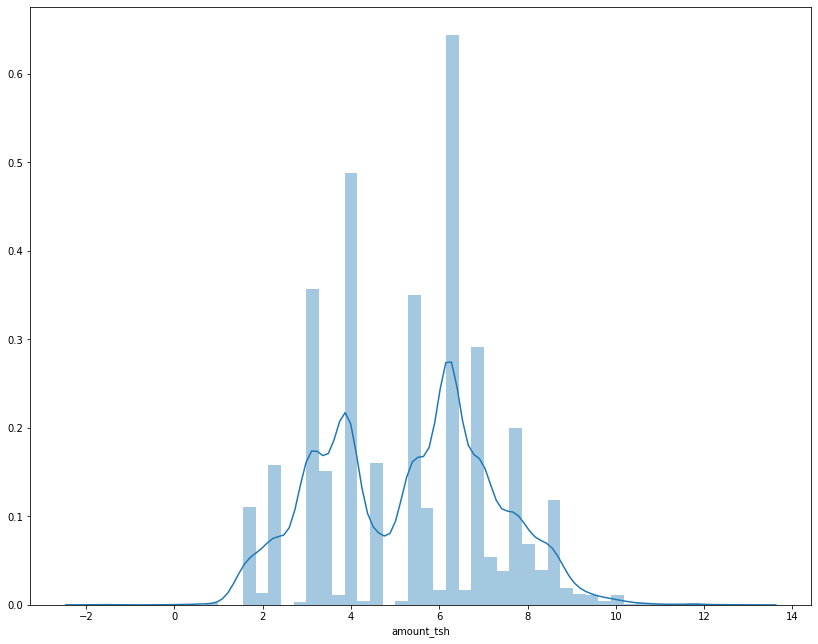

In [27]:
f, ax = plt.subplots(figsize=(14, 11))
non_zero_tsh = df_j[df_j["amount_tsh"]!= 0]["amount_tsh"]
logged_tsh = non_zero_tsh.map(lambda x: 0 if x<= 0 else math.log(x))
sns.distplot(logged_tsh)


After zero, the smallest measured value of total standing head is .2. For the purpose of not breaking the log transformation and maintaining the negative scale, I have imputed values that are based off of that minimum but reduced by a factor of 20 to keep maintain that relationship while capturing the fact that it was measured at zero in a dummy variable.

### Evaluating any affect of population size

I began by exploring the relationship between the size of the population and the condition of the well.

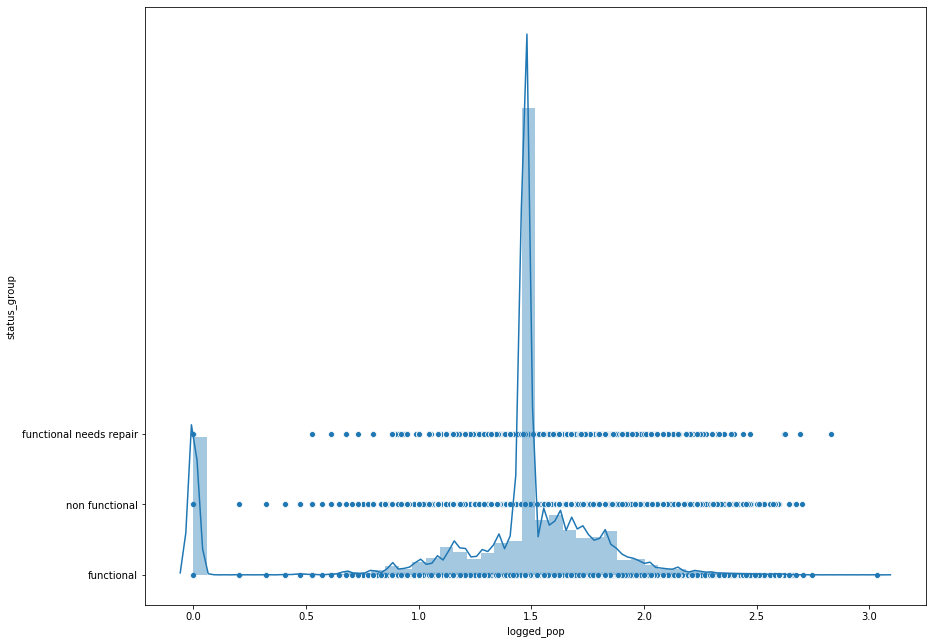

In [15]:
df_j["logged_pop"] = df_j["population"].map(lambda x: 0 if x<= 0 else math.log(x, 30))
f, ax = plt.subplots(figsize=(14, 11))
sns.distplot(df_j["logged_pop"])
sns.scatterplot(x="logged_pop", y=target_col, data=df_j)

It appears that the population values can be subset into two distinct groups. Half of which are registered with no population, while the other half follow an approximate normal distribute when a heavy log transformation is applied,

In [69]:
df_non_zero_pop = df_j[df_j["logged_pop"] != 0]
df_non_zero_pop[["logged_pop", target_col]].groupby(target_col).mean()

,logged_pop
status_group,
functional,1.507603
functional needs repair,1.583825
non functional,1.584797


In [77]:
#ANOVA test comparing the logged population size between the outcomes
formula = 'logged_pop ~ C(status_group)'
lm = ols(formula, df_non_zero_pop).fit()
table = sm.stats.anova_lm(lm, typ=2)
print("ANOVA for all outcomes")
print(table)

ANOVA for all outcomes
                      sum_sq       df           F        PR(>F)
C(status_group)    44.706518      2.0  217.096115  2.348120e-94
Residual         3190.982254  30991.0         NaN           NaN


A P value that small was likely a result between the difference in population between the whether a well currently worked or not(distinctions between how they weren't working was much less). A non linear relationship prevents it from being useful in any logistic regression, however it is interesting to note the relationship.

Perhaps there is a small sampling bias that is introduced where larger populations bring non functional wells to attention more or heavier use is affecting the degradation.

In [106]:
#Grabs the respective counts of well functionality in the provided data.
totals = df_j[["logged_pop", target_col]].groupby(target_col).count()["logged_pop"]

#Dataframe only the wells that have zeros input for population.
df_zero_pop = df_j[df_j["logged_pop"] == 0]

#Returns proportions for missing population data depending on the status of the well.
print(totals.index)
df_zero_pop[["logged_pop", target_col]].groupby(target_col).count()["logged_pop"]/totals.values

Index(['functional', 'functional needs repair', 'non functional'], dtype='object', name='status_group')


status_group
functional                 0.439722
functional needs repair    0.493167
non functional             0.529793
Name: logged_pop, dtype: float64

The proportions of zeros in population data vary among the different outcomes in the sample. In order to preserve that information, when imputing median, I will create a dummy variable that indicates a zero value while preserving the rest of the continuous entries. While the histogram indicates that there remains a disproportionatly large block of nonzero population sizes at very small values, doing the same process to would likely negatively impact the model.

## Putting them together

### TSH VS Years old

In [14]:
df_j["logged_tsh"] = df_j["amount_tsh"].map(lambda x: math.log(x))

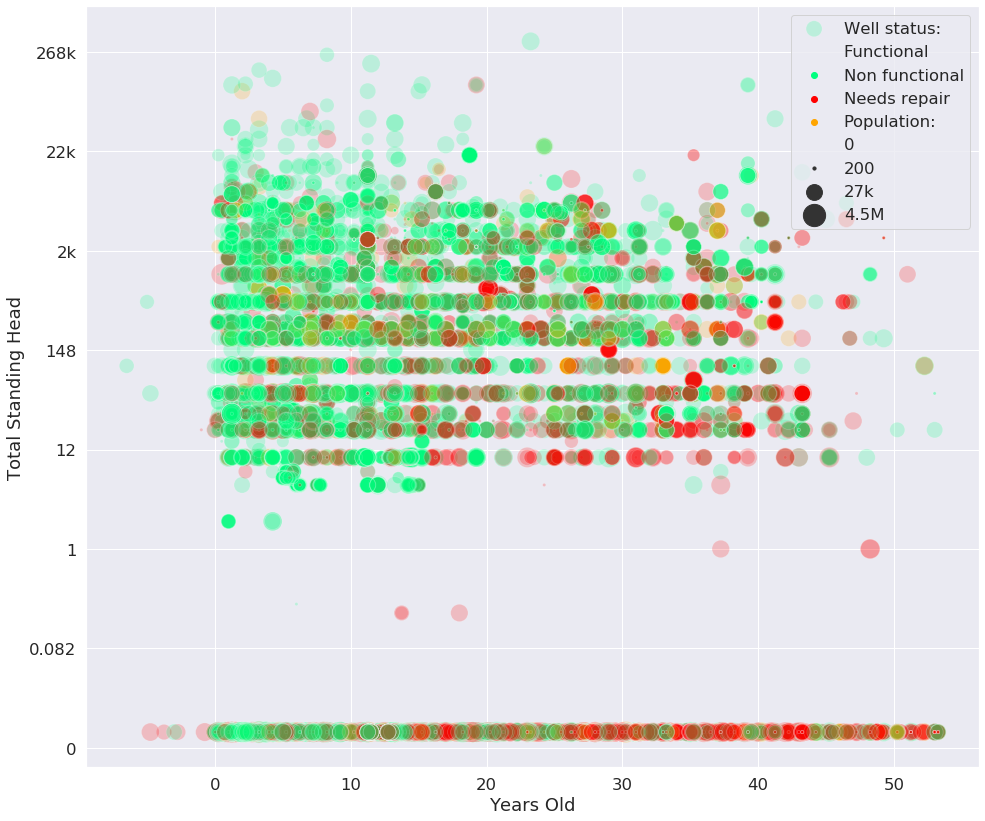

In [106]:
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
f, ax = plt.subplots(figsize=(16, 14))
functional_pal = {"functional":"springgreen", "functional needs repair":"orange", "non functional":"red"}
sns.scatterplot(x="years_old", y="logged_tsh", hue=target_col,
                    size="logged_pop", sizes=(10, 500), alpha=.2, palette=functional_pal,
                    data = df_j)
lgnd = ["Well status:", "Functional", "Non functional", "Needs repair",
       "Population:", "0", "200", "27k", "4.5M"]
ax.legend(lgnd)
ax.set_ylabel('Total Standing Head')
ax.set_xlabel('Years Old')
ticks = list(np.arange(-5,15,2.5))
tick_labels = unlog_plot(ticks, math.e)
tick_labels.insert(1, "0")
ax.set(yticklabels=tick_labels)
plt.show()

-6.5

### Correlation heatmap

<Figure size 1080x720 with 0 Axes>

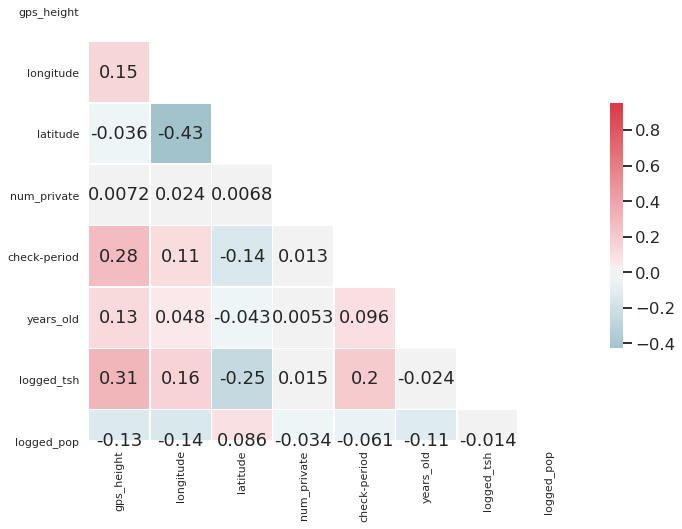

In [137]:
cont_features = ["gps_height", "longitude", "latitude",
                "num_private", "check-period", "years_old",
               "logged_tsh", "logged_pop"]

trimmed_heatmap(df_c, cont_features)

### scratch

In [103]:
math.log(df_j["amount_tsh"].max())

12.765688433465597

In [ ]:
cat_cols = ["quality_group"]
df_j.quality_group.unique()
sns.distplot(target_col, labels=cat_cols)

In [ ]:
data = DataPreprocessor(df_j, target_col, cont_features=cont_features, scale_type="minmax", poly_degree=2)

In [ ]:
model = ModelSwitcher(data, duplicate=True)

In [ ]:
model.data.poly_degree = 1
model.data._poly_features()
model.data.X

# Feature Engineering/Selection

In [11]:
# df_j["month_checked"] = df_j["date_recorded"].map(lambda x: x.month)
df_j = add_features(df_j)

# month_totals = totals = df_j[["logged_pop", target_col]].groupby(target_col).count()["logged_pop"]
df_j

# sns_scatterplot
# df_j.groupby("month_checked").count()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,missing_construction_year,missing_population,missing_public_meeting,missing_permit,check-season,check-period,years_old
0,69572,6000.00,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109.0,True,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,0,0,0,0,summer,0.309017,12.25
1,8776,0.01,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280.0,True,Other,Unknown,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,0,0,1,0,summer,0.436651,3.25
2,34310,25.00,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250.0,True,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,0,0,0,0,summer,0.570242,4.25
3,67743,0.01,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58.0,True,VWC,Unknown,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,0,0,0,0,summer,0.886071,27.00
4,19728,0.01,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,150.0,True,Unknown,Unknown,True,2000.0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,1,1,0,0,winter,-0.980469,11.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.00,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125.0,True,Water Board,Losaa Kia water supply,True,1999.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,0,0,0,0,fall,-0.519744,14.25
59396,27263,4700.00,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56.0,True,VWC,Ikondo electrical water sch,True,1996.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional,0,0,0,0,fall,-0.577292,15.25
59397,37057,0.01,2011-04-11,Unknown,0,Unknown,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,150.0,True,VWC,Unknown,False,2000.0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional,1,1,0,0,fall,-0.167052,11.25
59398,31282,0.01,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,150.0,True,VWC,Unknown,True,2000.0,nira/tanira,nira/tanira,handpump,vwc,

In [14]:
df_j[[target_col, "years_old"]].groupby(target_col).mean()

,years_old
status_group,
functional,12.253859
functional needs repair,15.125724
non functional,17.069718


In [32]:
print(df_j["seasonal_period"].max())
df_j[[target_col, "seasonal_period"]].groupby(target_col).mean()

0.9998518392091162


,seasonal_period
status_group,
functional,0.191443
functional needs repair,0.223154
non functional,0.204427


# Missing longitude and latitude

In [131]:
df_j[df_j["longitude"]==0]
df_j[(df_j["region"]=="Shinyanga")&(df_j["gps_height"]>0)]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,missing_construction_year,missing_population,check-season,check-period,years_old,logged_tsh,logged_pop
383,16341,0.01,2012-10-21,Wvt,1362,WVT,34.217656,-2.974327,Mtakuja,0,Lake Victoria,Mtakuja,Shinyanga,17,1,Bariadi,Mhunze,450.0,True,GeoData Consultants Ltd,WUG,NaN,False,2008.0,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,0,0,spring,0.357698,4.75,-4.605170,1.796205
764,53188,0.01,2013-02-14,Dwsp,1356,DWE,34.144579,-2.956513,Gasela,0,Lake Victoria,Matare,Shinyanga,17,1,Bariadi,Lagangabilili,500.0,True,GeoData Consultants Ltd,WUG,NaN,False,1996.0,swn 80,swn 80,handpump,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair,0,0,summer,0.714673,17.00,-4.605170,1.827182
795,59179,1000.00,2012-10-21,Lwi,1328,LWI,34.175690,-2.972687,Upendo,0,Lake Victoria,Kiluluma,Shinyanga,17,1,Bariadi,Mhunze,300.0,True,GeoData Consultants Ltd,WUG,NaN,False,2005.0,india mark ii,india mark ii,handpump,wug,user-group,pay when scheme fails,on failure,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,0,0,spring,0.357698,7.75,6.907755,1.676992
1291,25248,0.01,2013-01-31,Dwsp,1340,DWE,34.042961,-2.954429,Mwamabondo,0,Lake Victoria,Musoma,Shinyanga,17,1,Bariadi,Nkoma,250.0,False,GeoData Consultants Ltd,WUG,NaN,False,1998.0,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair,0,0,summer,0.860961,15.00,-4.605170,1.623387
1666,18326,0.01,2013-02-14,Dwsp,1354,DWE,34.176786,-2.928304,Tumaini,0,Lake Victoria,Ndolelezi,Shinyanga,17,1,Bariadi,Lagangabilili,500.0,True,GeoData Consultants Ltd,WUG,NaN,False,1997.0,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair,0,0,summer,0.714673,16.00,-4.605170,1.827182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58303,43154,0.01,2012-10-22,Rwssp,1378,DWE,34.235404,-2.966587,Maelewano,0,Lake Victoria,Matumbi,Shinyanga,17,1,Bariadi,Mhunze,500.0,True,GeoData Consultants Ltd,WUG,NaN,False,2005.0,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair,0,0,spring,0.373720,7.75,-4.605170,1.827182
58464,73405,0.01,2013-02-02,Dwsp,1311,DWE,34.001878,-3.016739,Njiapanda,0,Lake Victoria,Mwambaga Magharibi,Shinyanga,17,1,Bariadi,Nkoma,1.0,False,GeoData Consultants Ltd,WUG,NaN,False,1999.0,other,other,other,wug,user-group,never pay,never pay,unknown,unknown,dry,dry,other,other,unknown,other,other,non functional,0,0,summer,0.842942,14.00,-4.605170,0.000000
58762,57385,0.01,2012-10-21,Wvt,1359,WVT,34.232772,-2.936518,Twende Na Wakati,0,Lake Victoria,Mwakiliyoma,Shinyanga,17,1,Bariadi,Mhunze,360.0,True,GeoData Consultants Ltd,WUG,NaN,False,2007.0,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,0,0,spring,0.357698,5.75,-4.605170,1.730598
58789,13602,500.00,2013-01-31,Wv

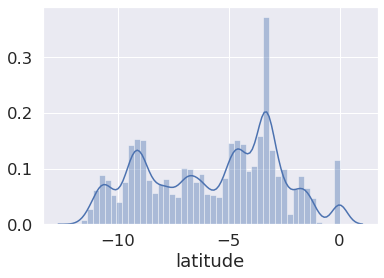

In [124]:
sns.distplot(df_j["latitude"])

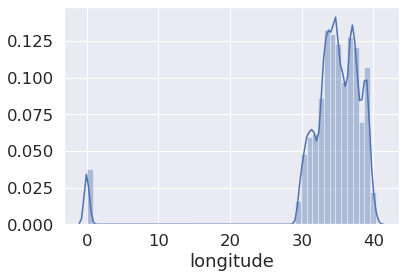

In [123]:
sns.distplot(df_j["longitude"])

# Dealing with missing GPS height

In [114]:
df_j[(df_j["gps_height"]>0) & (df_j["gps_height"]<10)]
df_j["gps_height"].mean()

668.297239057239

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,missing_construction_year,missing_population,check-season,check-period,years_old,logged_tsh,logged_pop
34,41583,0.01,2011-02-23,NaN,-41,NaN,39.812912,-7.889986,Msikitini Wa Ijumaa,0,Rufiji,Kilombero B,Pwani,60,63,Mafia,Baleni,100.0,True,GeoData Consultants Ltd,VWC,NaN,False,2000.0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,1,0,summer,0.598181,11.25,-4.60517,1.353985
39790,66420,0.01,2011-02-23,NaN,-43,NaN,39.819169,-7.890459,Kanisani,0,Rufiji,Kilombero A,Pwani,60,63,Mafia,Baleni,100.0,True,GeoData Consultants Ltd,VWC,NaN,False,2000.0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair,1,0,summer,0.598181,11.25,-4.60517,1.353985


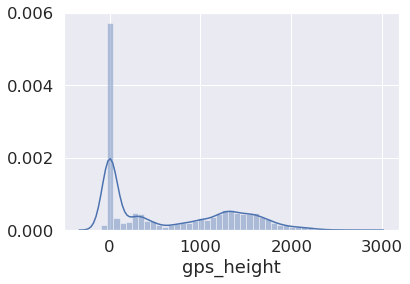

In [121]:
sns.distplot(df_j["gps_height"])
df_j[(df_j["gps_height"]<0)]
df_j[(df_j["longitude"]>39.812912) & (df_j["longitude"]<40.112912)& (df_j["latitude"]<-7.889986)& (df_j["latitude"]>-8.133632)]

# Missing num private

476      5
608      3
818      5
952      5
1197     5
        ..
14035    5
14194    1
14514    1
14639    2
14645    2
Name: num_private, Length: 253, dtype: int64

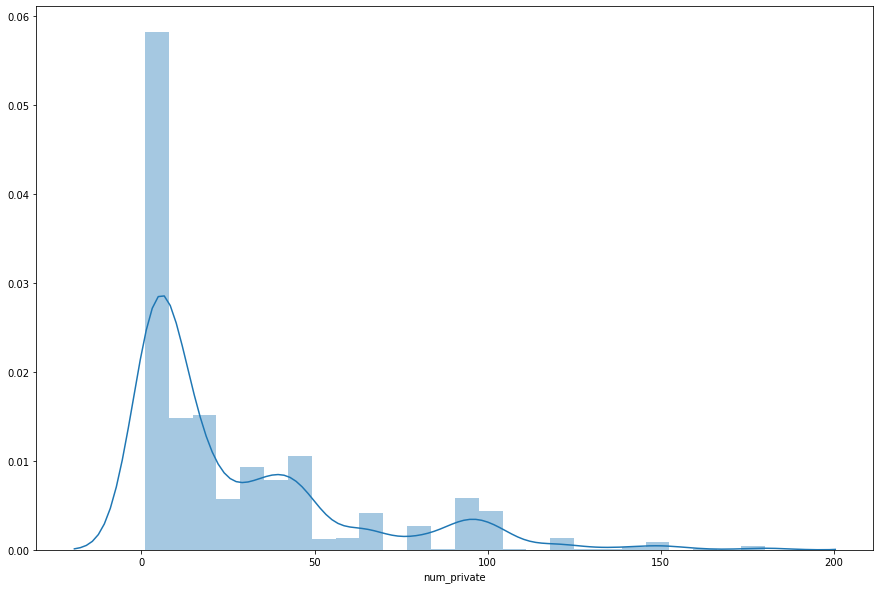

In [39]:
# sns.distplot()
plt.figure(figsize=(15, 10))
sns.distplot(df_c[(df_c["num_private"] !=0)&(df_c["num_private"] <=200)]["num_private"])
df_c[(df_c["num_private"] !=0)&(df_c["num_private"] <=5)]["num_private"]

# The model

In [6]:
#Importing external libraries
import math
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
import xgboost as xgb

#Importing classes and functions from external files:
from model_classes import ModelSwitcher, DataPreprocessor, evaluate_model
from cleaning_functions import *
from feature_engineering import *
from visualization_functions import *

#Configuring options
%matplotlib inline
pd.set_option('display.max_columns', 50)
df1 = pd.read_pickle("basic_cleaned")

In [3]:
target_col = "status_group"
categorical = {
    "nominal_features":["funder", "installer", "wpt_name", "basin", "subvillage",
                    "region", "region_code", "lga", "ward", "public_meeting",
                   "scheme_management", "scheme_name", "permit",
                   "extraction_type", "extraction_type_group", "extraction_type_class",
                    "management", "management_group", "payment", "payment_type",
                    "water_quality", "quality_group", "source", "source_type", "source_class",
                    "waterpoint_type", "waterpoint_type_group"
                   ],
    "impute_dummies":extract_column_names(df1, "^missing_")
}

categorical = {
    "nominal_features":["basin", "region", "region_code", "public_meeting",
                   "scheme_management", "permit",
                   "extraction_type", "extraction_type_group", "extraction_type_class",
                    "management", "management_group", "payment", "payment_type",
                    "water_quality", "quality_group", "source", "source_type", "source_class",
                    "waterpoint_type", "waterpoint_type_group"
                   ],
    "impute_dummies":extract_column_names(df1, "^missing_")
}
continuous = {"untransformed":["gps_height", "longitude", "latitude", "num_private",
                               "check-period", "years_old"],
             "transformed": {"logged": {"population":30, "amount_tsh":None}
             }}

In [10]:
#  categorical,
data = DataPreprocessor(df1, target_col, categorical, continuous, True, True, True, True)
data.data_preprocessing(balance_class="upsample", scale_type="minmax", poly_degree=False)
data.X_train

Creating Dummies
Skipping polynomial features
Performing upsample
Using Min/Max scaler


,gps_height,longitude,latitude,num_private,check-period,years_old,population_log_b30,amount_tsh_ln,missing_construction_year,missing_population,missing_public_meeting,missing_permit,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,...,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,source_class_surface,source_class_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
1159,0.033113,0.793776,0.712740,0.000000,0.734164,0.322176,0.485269,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26556,0.668874,0.859620,0.217848,0.000000,0.055005,0.669456,0.444044,0.622870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
50388,0.041575,0.963831,0.518136,0.029244,0.679296,0.715481,0.634458,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12301,0.052612,0.968854,0.401307,0.000000,0.638467,0.163180,0.446001,0.530218,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
42506,0.537528,0.866126,0.153421,0.000000,0.654939,0.313808,0.389846,0.765920,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45933,0.033113,0.831803,0.256636,0.000000,0.519699,0.297071,0.485269,0.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
38726,0.593451,0.881934,0.630498,0.000000,0.839364,0.129707,0.580260,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
57393,0.033113,0.789332,0.910557,0.000000,0.040366,0.301255,0.485269,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
44725,0.282193,0.913610,0.028003,0.000000,0.863877,0.393305,0.000000,0.726017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
forest = RandomForestClassifier(n_estimators=200, max_depth=5, criterion='gini', n_jobs=-1, random_state=101)
forest.fit(data.X_train, data.y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=101, verbose=0,
                       warm_start=False)

In [6]:
evaluate_model(forest, data.X_test, data.y_test)

F1 Score: 0.5702861952861953
Accuracy: 0.5702861952861953


In [12]:
param_dist = {'n_estimators':[100,500,900],
              'criterion':["gini", "entropy"],
              'max_depth':[3,8,13],
              'min_samples_split':[2,7,12],
              'min_samples_leaf':[1,9,17],
              "min_impurity_decrease":[0,.1, .2]
             }
param_dist = {'n_estimators':[501,900,1300],
              'criterion':["entropy"],
              'max_depth':[8,13,18],
              'min_samples_split':[2,4,6],
              'min_samples_leaf':[1,5,9],
              "min_impurity_decrease":[0,.05, .09]
             }
g_forest = GridSearchCV(estimator=forest,
                   param_grid=param_dist,
                   scoring='accuracy',
                   n_jobs=-1,
                   verbose=1,
                   iid=False,
                   cv=5)
g_forest.fit(data.X_train, data.y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 33.0min
/home/corey/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 54.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 103.3min
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed: 178.5min finished
/home/corey/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=-1,
                                              oob_score=False, random_state=101,
                                      

In [44]:
g_forest.best_params_

{'criterion': 'entropy',
 'max_depth': 13,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 900}

In [13]:
g_forest.best_params_

{'criterion': 'entropy',
 'max_depth': 18,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 900}

In [46]:
evaluate_model(g_forest, data.X_test, data.y_test)

F1 Score: 0.6804713804713804
Accuracy: 0.6804713804713804


In [14]:
evaluate_model(g_forest, data.X_test, data.y_test)

F1 Score: 0.7292929292929293
Accuracy: 0.7292929292929293


In [17]:
forest = RandomForestClassifier(**g_forest.best_params_)
forest.fit(data.X_train, data.y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=18, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=900,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [18]:
evaluate_model(forest, data.X_test, data.y_test)

F1 Score: 0.727020202020202
Accuracy: 0.727020202020202


In [8]:
clg_xgb = xgb.XGBClassifier(objectives='objective=multi:softmax')
param_dist = {'n_estimators':[100,500,900],
              'learning_rate':[0.05,0.5,.95],
              'max_depth':[1,5,9],
              'colsample_bytree':[.25, 0.5, 0.75],
              'min_child_weight':[1,5,9],
              'subsample':[1, 7.5, .5],
              'lambda':[1,5,9],
              'alpha':[0,5,10],
             }
param_dist = {'n_estimators':[100,500,900],
              'learning_rate':[0.05,0.5,.95],
              'max_depth':[1,5,9],
              'colsample_bytree':[.25, 0.5, 0.75],
              'min_child_weight':[1,5,9],
              'subsample':[1, 7.5, .5],
             }
xgg = GridSearchCV(estimator=clg_xgb,
                   param_grid=param_dist,
                   scoring='accuracy',
                   n_jobs=-1,
                   verbose=1,
                   iid=False,
                   cv=10)

xgg.fit(data.X_train, data.y_train)

Fitting 10 folds for each of 729 candidates, totalling 7290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 127.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 404.3min


KeyboardInterrupt: 

In [29]:
evaluate_model(forest, data.X_test, data.y_test)

F1 Score: 0.5702861952861953
Accuracy: 0.5702861952861953


In [5]:
full_value_counts(data.df, "lga")

There are 125 unique values with 0 nan values making up 0.0%
2503-Njombe
1252-Arusha Rural
1251-Moshi Rural
1177-Bariadi
1106-Rungwe
1094-Kilosa
1047-Kasulu
1034-Mbozi
1009-Meru
997-Bagamoyo
995-Singida Rural
959-Kilombero
877-Same
874-Kibondo
859-Kyela
836-Kahama
824-Magu
824-Kigoma Rural
809-Maswa
771-Karagwe
750-Mbinga
728-Iringa Rural
716-Serengeti
694-Namtumbo
694-Lushoto
693-Songea Rural
679-Mpanda
671-Mvomero
669-Ngara
665-Ulanga
630-Makete
627-Kwimba
626-Mbarali
625-Hai
594-Rombo
588-Shinyanga Rural
575-Nzega
564-Ludewa
560-Mkuranga
544-Iramba
528-Masasi
523-Kondoa
521-Sumbawanga Rural
521-Morogoro Rural
520-Mufindi
519-Mwanga
514-Bukombe
511-Babati
497-Ilala
488-Geita
487-Bukoba Rural
485-Mbeya Rural
468-Meatu
454-Rufiji
438-Bunda
434-Siha
428-Nkasi
423-Mtwara Rural
423-Tunduru
412-Korogwe
403-Biharamulo
402-Muleba
399-Kishapu
396-Musoma Rural
392-Kilwa
388-Mpwapwa
388-Lindi Rural
382-Urambo
377-Manyoni
361-Kongwa
358-Dodoma Urban
349-Kilolo
348-Missungwi
347-Chamwino
341-Uker

In [6]:
data.cols_standard_dummies

Index([], dtype='object')

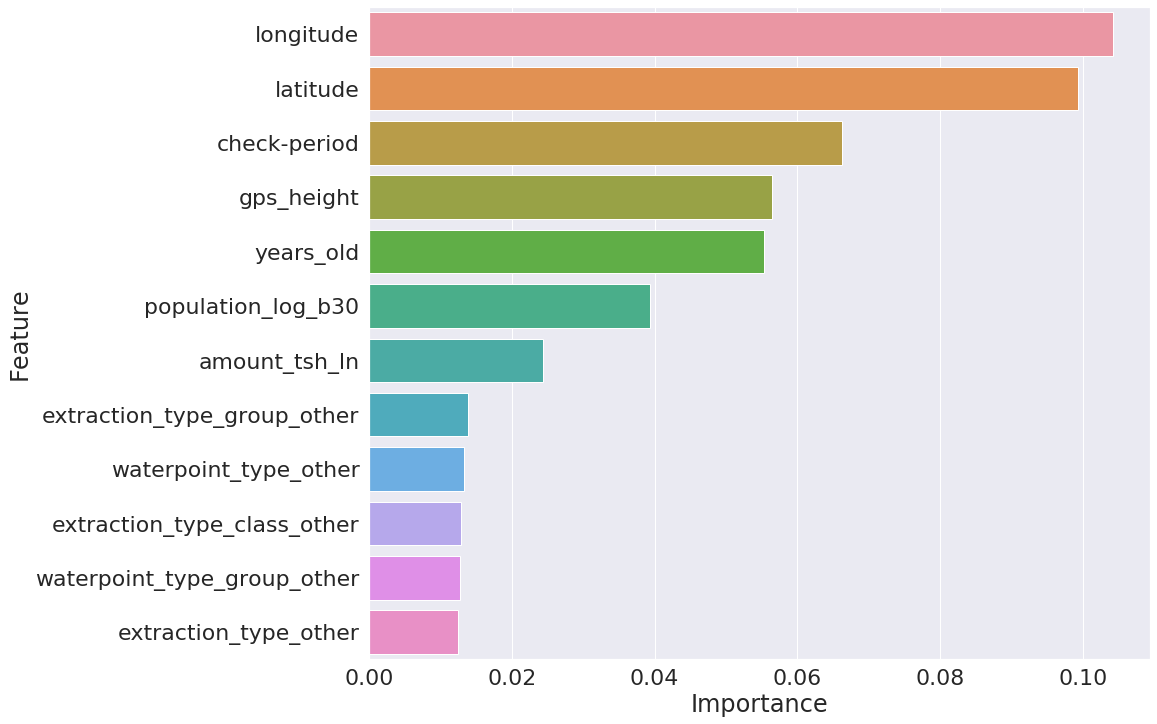

In [31]:
f, ax = plt.subplots(figsize=(14, 12))
sns.set(font_scale=1)
importance = pd.DataFrame(forest.feature_importances_, index=data.X_train.columns).reset_index()
importance.columns = pd.Index(["Feature", "Importance"])
sns.barplot(y="Feature", x="Importance", data=importance.sort_values("Importance", ascending=False).iloc[0:12])